#Image Recognition Wajah Presiden RI

## IMPORT LIBRARY

In [ ]:
import os
from shutil import copy2
import csv

In [ ]:

from __future__ import absolute_import, division, print_function, unicode_literals

try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:

!pip install tensorflow_hub

In [ ]:
import tensorflow_hub as hub

In [ ]:

tf.__version__

'2.15.0'

#PREPROCESSING DATA

In [ ]:
import pandas as pd

# Tingkatkan presisi data yang disajikan untuk perbandingan berdampingan yang lebih baik
pd.set_option("display.precision", 8)

In [ ]:
data_root = ("/content/train") #Path untuk dataset yang telah dibagi kelasnya dalamn folder

In [ ]:
IMAGE_SHAPE = (224, 224) # (height, width)

# TRAINING DATASET
Untuk melakukan training pada dataset serta split dataset dalam train and validation

In [ ]:
TRAINING_DATA_DIR = str(data_root)

In [ ]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)

In [ ]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    TRAINING_DATA_DIR,
    subset="validation",
    shuffle=True,
    target_size=IMAGE_SHAPE
)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR,
    subset="training",
    shuffle=True,
    target_size=IMAGE_SHAPE)


Found 63 images belonging to 9 classes.
Found 273 images belonging to 9 classes.


In [ ]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((32, 224, 224, 3), (32, 9))

Melakukan Generate pada label kedalam text

In [ ]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'.ipynb_checkpoints': 0, 'gusdur': 1, 'habibie': 2, 'jokowi': 3, 'mega': 4, 'prabowo': 5, 'sby': 6, 'soeharto': 7, 'soekarno': 8}


Ini adalah utilitas baris perintah yang digunakan untuk menggabungkan dan menampilkan konten file. Namanya berasal dari "gabungan".

In [ ]:
!cat labels.txt

.ipynb_checkpoints
gusdur
habibie
jokowi
mega
prabowo
sby
soeharto
soekarno

In [ ]:

IMAGE_SIZE = 224



*  Model didefinisikan sebagai model Sequential, yang berarti layer-layer ditumpuk secara berurutan.
*  Layer pertama menggunakan hub.KerasLayer untuk memuat extractor fitur MobileNetV2 yang telah dilatih sebelumnya dari TensorFlow Hub. Layer ini mengambil gambar sebagai input dan mengeluarkan vektor fitur berukuran 1280.
*  trainable=False menunjukkan bahwa parameter-parameter model MobileNetV2 tidak akan dilatih selama pelatihan, karena kita ingin menggunakan bobot yang sudah dilatih sebelumnya.
* Layer Dropout dengan tingkat dropout sebesar 0.4 ditambahkan untuk mengurangi overfitting.
* Terakhir, sebuah layer Dense dengan jumlah unit yang sama dengan jumlah kelas dalam data latihan ditambahkan. Fungsi aktivasi yang digunakan adalah softmax, yang umum digunakan untuk klasifikasi multi-kelas.



In [ ]:

model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
                 output_shape=[1280],
                 trainable=False),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 9)                 11529     
                                                                 
Total params: 2269513 (8.66 MB)
Trainable params: 11529 (45.04 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


* Optimizer: Adam adalah algoritma optimisasi yang populer digunakan dalam pelatihan jaringan saraf. Adam singkatan dari Adaptive Moment Estimation dan menggabungkan keuntungan dari dua ekstensi dari stochastic gradient descent lainnya, yaitu AdaGrad dan RMSProp.

* Learning Rate (lr): Tingkat pembelajaran menentukan ukuran langkah yang diambil selama proses optimisasi. Tingkat pembelajaran sebesar 1e-3 (0.001) adalah pilihan umum untuk banyak tugas pelatihan jaringan saraf. Ini tidak terlalu besar untuk menyebabkan perilaku yang divergen dan tidak terlalu kecil untuk melambatkan konvergensi secara signifikan.

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr=1e-3)

* optimizer=optimizer: Parameter ini menentukan optimizer yang akan digunakan selama proses pelatihan. Dalam kasus ini, Anda menggunakan optimizer yang telah Anda inisialisasi sebelumnya dengan nama optimizer.

* loss='categorical_crossentropy': Ini adalah fungsi kerugian yang akan digunakan selama pelatihan model. 'categorical_crossentropy' adalah pilihan umum untuk masalah klasifikasi multi-kelas di mana setiap sampel dapat dimasukkan ke dalam satu kelas saja. Fungsi kerugian ini sangat cocok untuk tugas-tugas di mana output model adalah distribusi probabilitas kelas.

* metrics=['acc']: Parameter ini menentukan metrik evaluasi yang akan digunakan untuk memantau kinerja model selama pelatihan dan evaluasi. Dalam hal ini, 'acc' mengacu pada akurasi klasifikasi, yang merupakan persentase jumlah prediksi yang benar dari semua prediksi.

In [ ]:
model.compile(
  optimizer=optimizer,
  loss='categorical_crossentropy',
  metrics=['acc'])


* steps_per_epoch: Variabel ini menentukan jumlah langkah (steps) yang akan diambil oleh model pada setiap epoch selama pelatihan. Ini dihitung dengan membagi jumlah sampel dalam data latihan dengan ukuran batch dari generator.

* val_steps_per_epoch: Variabel ini sama seperti steps_per_epoch, tetapi digunakan untuk data validasi.

* model.fit(): Metode fit() digunakan untuk melatih model. Dalam konteks ini, Anda memberikan generator data latihan (train_generator) dan data validasi (valid_generator) sebagai input. Anda juga menentukan berapa banyak epoch yang ingin Anda latih (epochs=50), langkah-langkah per epoch untuk data pelatihan dan data validasi, serta mengatur tingkat kebisingan (verbose) ke 1 untuk mencetak detail pelatihan.

* hist: Variabel ini berisi riwayat pelatihan model, termasuk metrik yang dipantau selama pelatihan seperti loss dan akurasi.

In [ ]:

steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

hist = model.fit(
    train_generator,
    epochs=50,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=val_steps_per_epoch).history

Epoch 1/50
9/9 [==============================] - 21s 2s/step - loss: 2.3448 - acc: 0.1868 - val_loss: 1.9225 - val_acc: 0.3016
Epoch 2/50
9/9 [==============================] - 14s 2s/step - loss: 1.7862 - acc: 0.3590 - val_loss: 1.5718 - val_acc: 0.4762
Epoch 3/50
9/9 [==============================] - 16s 2s/step - loss: 1.4993 - acc: 0.4542 - val_loss: 1.3825 - val_acc: 0.5714
Epoch 4/50
9/9 [==============================] - 14s 2s/step - loss: 1.2767 - acc: 0.5495 - val_loss: 1.2786 - val_acc: 0.5873
Epoch 5/50
9/9 [==============================] - 14s 2s/step - loss: 1.1636 - acc: 0.5934 - val_loss: 1.1640 - val_acc: 0.6349
Epoch 6/50
9/9 [==============================] - 15s 2s/step - loss: 1.0125 - acc: 0.6520 - val_loss: 1.0827 - val_acc: 0.6825
Epoch 7/50
9/9 [==============================] - 13s 1s/step - loss: 0.8895 - acc: 0.6667 - val_loss: 1.0337 - val_acc: 0.7143
Epoch 8/50
9/9 [==============================] - 13s 2s/step - loss: 0.8909 - acc: 0.7033 - val_loss: 1

In [ ]:
final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

2/2 [==============================] - 2s 1s/step - loss: 0.7291 - acc: 0.8413
Final loss: 0.73
Final accuracy: 84.13%


* plt.figure(): Fungsi ini digunakan untuk membuat sebuah gambar kosong sebagai kanvas untuk grafik yang akan dibuat.

* plt.ylabel() dan plt.xlabel(): Mengatur label sumbu y dan x pada grafik.

* plt.ylim([0, 50]) dan plt.ylim([0, 1]): Mengatur rentang sumbu y pada grafik untuk loss dan akurasi.

* plt.plot(): Fungsi ini digunakan untuk memplot data pada grafik. Argument pertama adalah data yang ingin Anda plot. Dalam kasus ini, Anda ingin memplot loss pelatihan dan validasi (hist["loss"] dan hist["val_loss"]) serta akurasi pelatihan dan validasi (hist["acc"] dan hist["val_acc"]).

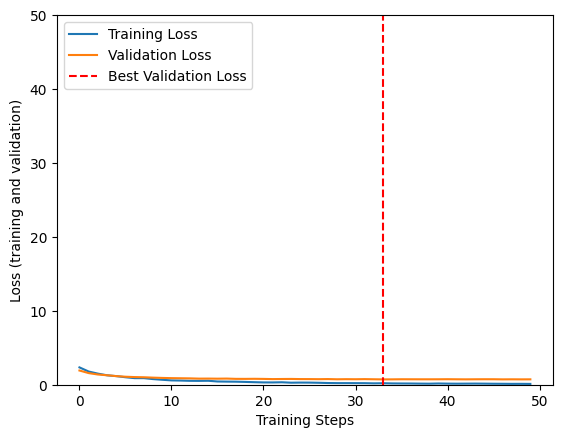

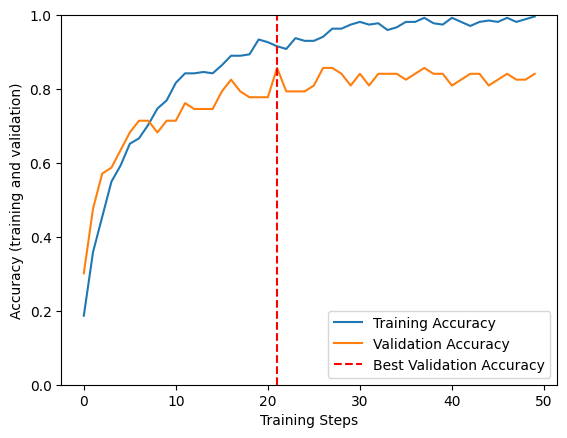

In [ ]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,50])
plt.plot(hist["loss"], label='Training Loss')
plt.plot(hist["val_loss"], label='Validation Loss')
plt.axvline(x=np.argmin(hist["val_loss"]), color='r', linestyle='--', label='Best Validation Loss')
plt.legend()

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["acc"], label='Training Accuracy')
plt.plot(hist["val_acc"], label='Validation Accuracy')
plt.axvline(x=np.argmax(hist["val_acc"]), color='r', linestyle='--', label='Best Validation Accuracy')
plt.legend()


In [ ]:
model.save('recog.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


* train_generator.class_indices: Ini adalah atribut dari generator data yang menyimpan kamus yang memetakan nama kelas ke indeks kelas.

* sorted(): Fungsi ini digunakan untuk mengurutkan item dalam kamus berdasarkan nilai indeksnya.

* lambda pair:pair[1]: Ini adalah fungsi lambda yang digunakan sebagai kunci untuk mengurutkan item berdasarkan nilai kedua dalam pasangan kunci-nilai (yaitu, nilai indeks kelas).

* np.array([key.title() for key, value in dataset_labels]): Ini mengonversi label kelas menjadi array numpy dan memastikan bahwa setiap kata diawali dengan huruf kapital (menggunakan .title()).

* print(dataset_labels): Ini mencetak label kelas yang telah diurutkan dan dinormalisasi.

In [ ]:

dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)


['.Ipynb_Checkpoints' 'Gusdur' 'Habibie' 'Jokowi' 'Mega' 'Prabowo' 'Sby'
 'Soeharto' 'Soekarno']


In [ ]:
tf_model_predictions = model.predict(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)

1/1 [==============================] - 3s 3s/step
Prediction results shape: (32, 9)


* np.argmax(tf_model_predictions, axis=-1): Fungsi np.argmax() digunakan untuk mencari indeks dengan nilai terbesar dalam array tf_model_predictions di sepanjang sumbu terakhir (axis=-1). Ini menghasilkan indeks dari kelas dengan probabilitas prediksi tertinggi untuk setiap sampel.

* predicted_labels = dataset_labels[predicted_ids]: Ini mengonversi indeks prediksi menjadi label-label kelas yang sesuai dengan indeks tersebut dalam array dataset_labels.


In [ ]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
print(predicted_labels)

['Mega' 'Mega' 'Habibie' 'Jokowi' 'Jokowi' 'Jokowi' 'Soeharto' 'Sby'
 'Jokowi' 'Habibie' 'Habibie' 'Jokowi' 'Habibie' 'Habibie' 'Mega' 'Sby'
 'Jokowi' 'Prabowo' 'Sby' 'Soeharto' 'Jokowi' 'Prabowo' 'Prabowo' 'Sby'
 'Habibie' 'Gusdur' 'Gusdur' 'Gusdur' 'Gusdur' 'Habibie' 'Habibie'
 'Prabowo']


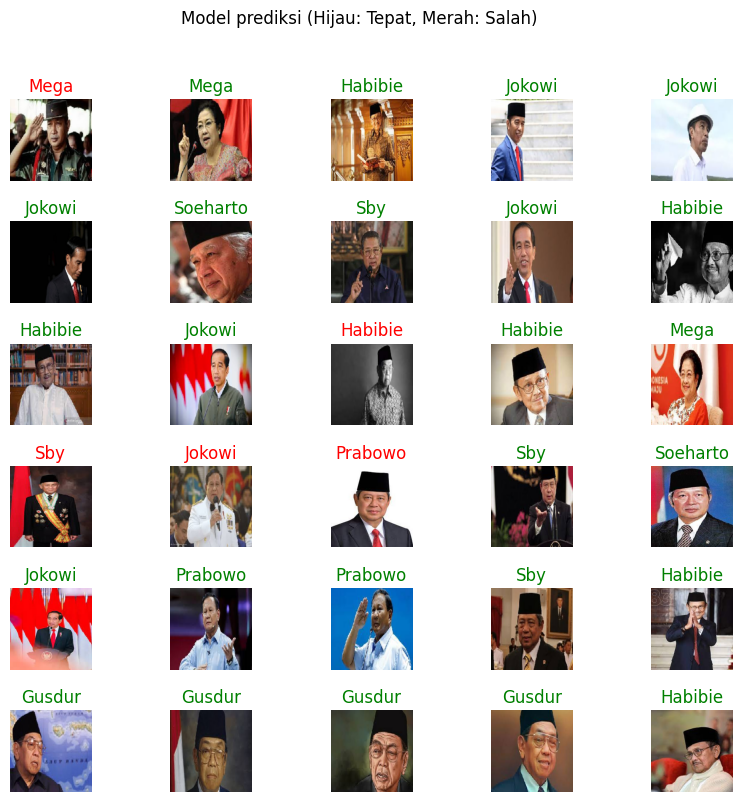

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range((len(predicted_labels)-2)):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model prediksi (Hijau: Tepat, Merah: Salah)")

In [ ]:
from tensorflow.keras.preprocessing import image as img
import matplotlib.pyplot as plt
import numpy as np

def predict_image(image_path, model, dataset_labels):
    # Load the image
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    # Normalize the image
    img_array /= 255.0

    # Buat Prediksi
    predictions = model.predict(img_array)
    predicted_id = np.argmax(predictions[0])
    predicted_label = dataset_labels[predicted_id]

    # Hasilnya
    plt.imshow(img)
    plt.title(predicted_label)
    plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 108ms/step


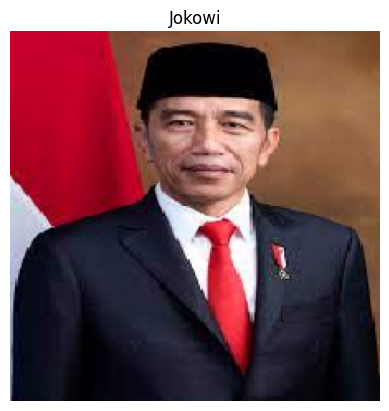

In [ ]:
# Contoh Pemakaian:
image_path = "download.jpg"
predict_image(image_path, model, dataset_labels)
